## Classifier to classify something about faces

In [90]:
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import pandas as pd
import numpy as np
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torch.nn.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
import os
import torchvision.transforms as transforms


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    #generator.cuda()
    #discriminator.cuda()
    #adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
    print(device)
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor

cuda:0


In [76]:
from skimage import io, transform
class FaceDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.df['img_name'][idx])
        image = io.imread(img_name)
        features = self.df.iloc[idx, 1:]
        features = np.array([features])[:,1:].astype('float32').reshape(8)

        if self.transform:
            image = self.transform(image)
            
        sample = (image, features)

        return sample
    
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

dataset = FaceDataset(csv_file='./data/celeba_smaller/reduced_attr.csv',
                                    root_dir='./data/celeba_smaller/img_align_celeba/',
                     transform=transform)

In [77]:
batch_size=32

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

In [78]:
dataiter = iter(dataloader)
real_image_examples, classes = dataiter.next()
n_classes = len(classes)

In [79]:
def imshow(img):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


In [81]:
n_classes = classes.shape[1]
n_classes

8

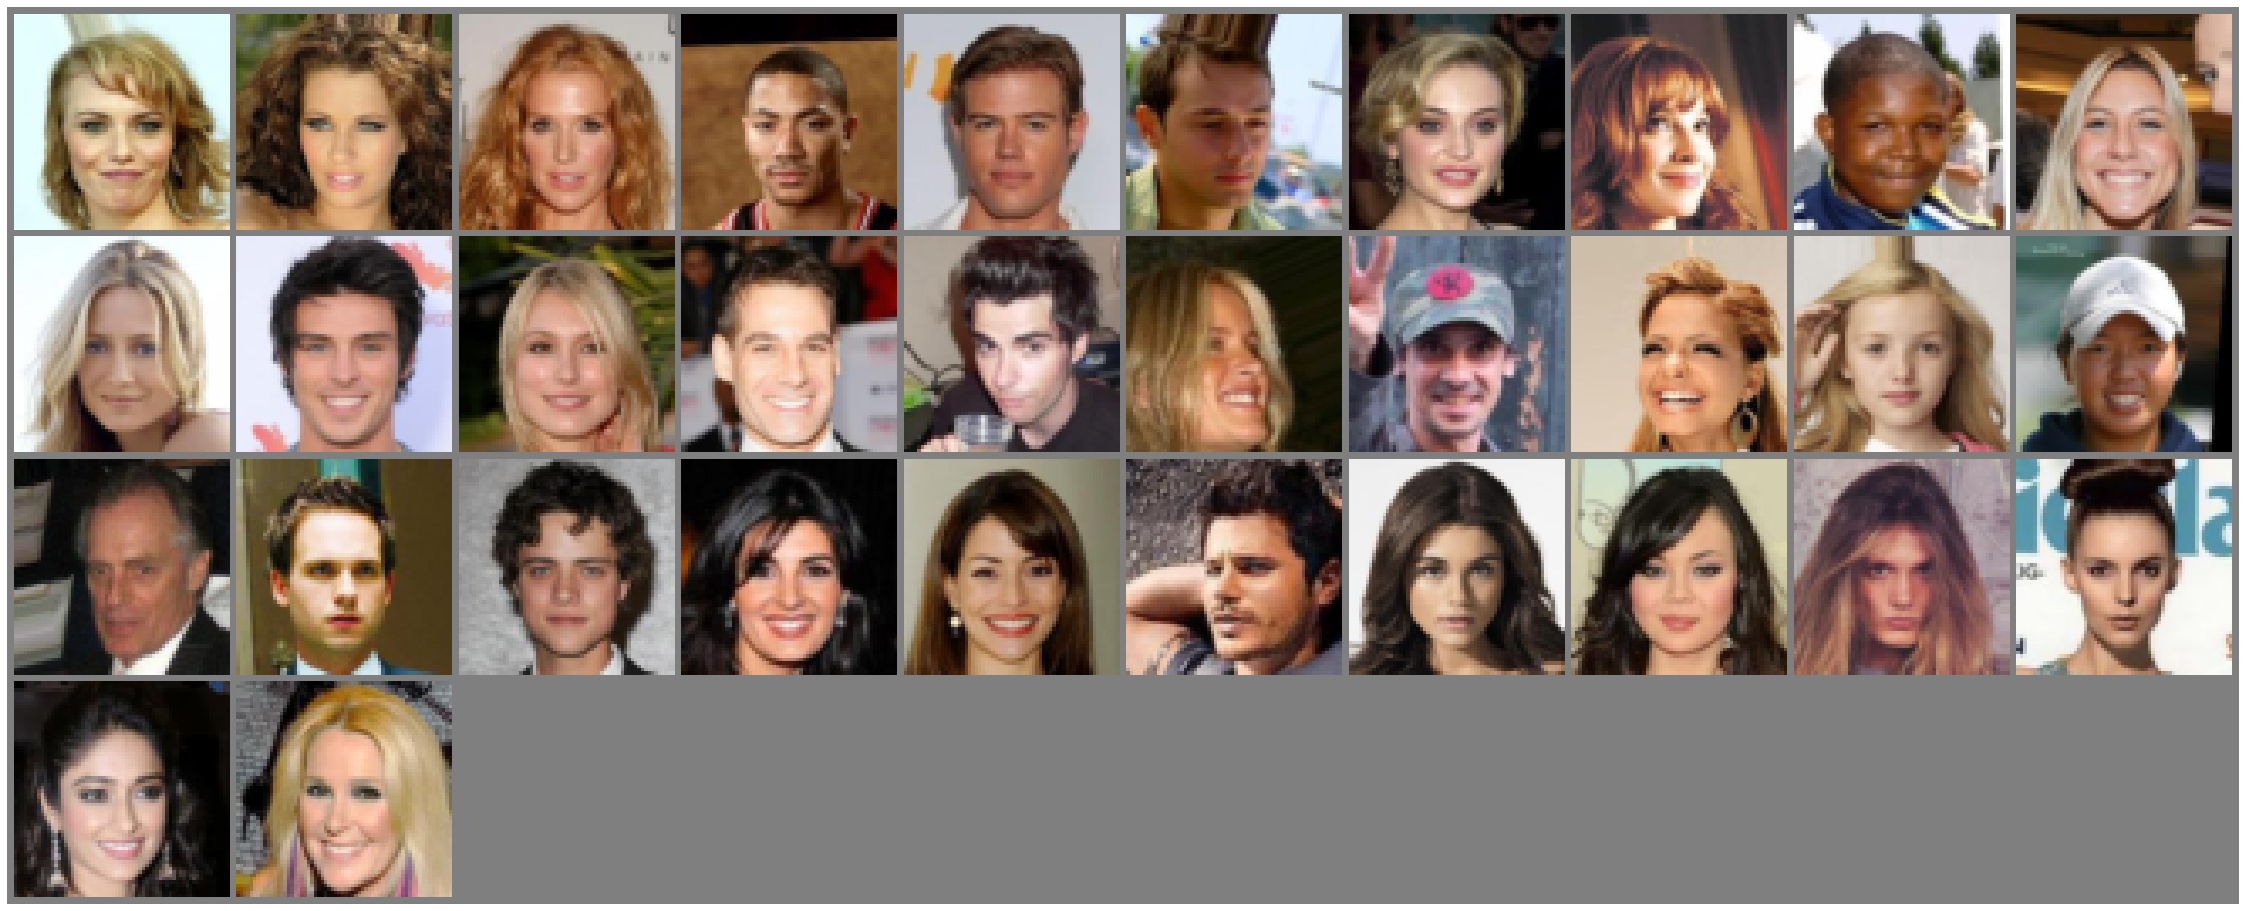

In [82]:
plt.figure(figsize=(40,40))
imshow(torchvision.utils.make_grid(real_image_examples[0:100], padding=2, normalize=False, nrow=10).cpu())

# Simple CONV to classify using our classes we have

In [112]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(128*8*8, 128*8), nn.ReLU(),
            nn.Linear(128*8, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, n_classes),
        )
        
        self.classify =  nn.Softmax(dim=1)
        
        
    def forward(self, img):
        out = self.conv_blocks(img)
        out = torch.flatten(out, start_dim=1)
        out = self.fully_connected(out)
        out = self.classify(out)
        return out

In [139]:
model = Classifier(8).to(device)
model(real_image_examples.to(device))

tensor([[0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1319],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.1220, 0.1171, 0.1172, 0.1224, 0.1318],
        [0.1312, 0.1341, 0.1242, 0.122

In [140]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [141]:
%%time
batch_size=64

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

dataiter = iter(dataloader)
real_image_examples, classes = dataiter.next()
n_classes = len(classes)


for epoch in range(3200):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        
        # zero the parameter grads
        optimizer.zero_grad()
        
        # forward, backward, optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    if epoch % 100 == 0:
        print(f'[{epoch + 1}] loss: {loss.item()}')

[1] loss: 2.0740761756896973
[101] loss: 1.6741037368774414
[201] loss: 1.61702561378479
[301] loss: 1.3949593305587769
[401] loss: 1.4127044677734375
[501] loss: 1.394850254058838
[601] loss: 1.413942575454712
[701] loss: 1.4125580787658691
[801] loss: 1.3266500234603882
[901] loss: 1.3410102128982544
[1001] loss: 1.4273030757904053
[1101] loss: 1.4122132062911987
[1201] loss: 1.4286346435546875
[1301] loss: 1.3760483264923096
[1401] loss: 1.394972324371338
[1501] loss: 1.393295168876648
[1601] loss: 1.4277921915054321
[1701] loss: 1.344193696975708
[1801] loss: 1.4278019666671753
[1901] loss: 1.4264178276062012
[2001] loss: 1.3765181303024292
[2101] loss: 1.3434609174728394
[2201] loss: 1.3782943487167358
[2301] loss: 1.3945974111557007
[2401] loss: 1.4101804494857788
[2501] loss: 1.3400027751922607
[2601] loss: 1.378961443901062
[2701] loss: 1.3434134721755981
[2801] loss: 1.3602420091629028
[2901] loss: 1.3266632556915283
[3001] loss: 1.3767738342285156
[3101] loss: 1.3439791202545

In [142]:
classes.argmax(dim=1)

tensor([0, 7, 6, 0, 5, 6, 0, 1, 0, 5, 1, 2, 6, 6, 6, 0, 0, 1, 2, 7, 6, 7, 6, 6,
        5, 7, 6, 4, 7, 6, 7, 6, 7, 7, 7, 0, 3, 1, 6, 0, 6, 0, 6, 0, 7, 5, 5, 0,
        5, 0, 0, 6, 0, 7, 5, 0, 4, 7, 5, 7, 5, 7, 7, 6])

In [143]:
dataiter = iter(dataloader)
train_acc = 0.0
number_of_data_points = 0
for i in range(len(dataiter)):
    inputs, classes = next(dataiter)
    outputs = model(inputs.to(device))
    train_acc += torch.sum(outputs.argmax(dim=1).to(device) == classes.argmax(dim=1).to(device))
    number_of_data_points += len(inputs)
final_acc = train_acc/number_of_data_points

In [145]:
final_acc

tensor(0.9269, device='cuda:0')

In [69]:
model.conv_blocks(real_image_examples[1]).shape

torch.Size([128, 8, 8])

In [148]:
torch.save({'state_dict': model.state_dict()}, 'models/gan_models/face_classifier.pth')

<All keys matched successfully>

In [153]:
dataiter = iter(dataloader)
train_acc = 0.0
number_of_data_points = 0
for i in range(len(dataiter)):
    inputs, classes = next(dataiter)
    outputs = model1(inputs.to(device))
    train_acc += torch.sum(outputs.argmax(dim=1).to(device) == classes.argmax(dim=1).to(device))
    number_of_data_points += len(inputs)
final_acc = train_acc/number_of_data_points

In [154]:
final_acc

tensor(0.9269, device='cuda:0')